### SAAD To-do
    a cross validation procedure that we could use to interpret our machine learning
    results to specifically address a concern I had which is being able to interpret:
    - do our results deviate significantly from those expected under stochastic drift, 
    - versus differing significantly from other interesting things, such as the taxon
    cycle, ecological release, competition and not “just” being able to provide a long
    list of submodels by order of fit.

### Doing the ML with python because it's way easier

In [47]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import glob
import ipyparallel as ipp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from collections import Counter
from itertools import combinations
from IPython.display import display
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report,confusion_matrix,plot_confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score

pd.set_option('display.max_columns', None)

ipyclient = ipp.Client(cluster_id="iBioGen")
len(ipyclient)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


40

### This is all because of the stupid way I'm writing out the sims from julia
Ages are 1000-i because i is actually _colonization time_ and the sims ran for 1000 generations

In [200]:
scale_relative = False
infile = "SIMOUT.txt"
tmp_df = pd.read_csv(infile, sep="\t", header=None)
tmp_df.columns = ["e_s", "ndd", "ages", "abunds"]
ages = pd.DataFrame(map(lambda x: x.split(), tmp_df["ages"]), columns=[f"Age_{x}" for x in range(10)]).astype(int)
abunds = pd.DataFrame(map(lambda x: x.split(), tmp_df["abunds"]), columns=[f"Abunds_{x}" for x in range(10)]).astype(int)

if scale_relative:
    ages = ages.div(ages.sum(axis=1), axis=0)
    abunds = abunds.div(abunds.sum(axis=1), axis=0)

sims_df = pd.concat([tmp_df[["e_s", "ndd"]], ages, abunds], axis=1)
sims_df["model"] = np.zeros(len(sims_df))
sims_df

,e_s,ndd,Age_0,Age_1,Age_2,Age_3,Age_4,Age_5,Age_6,Age_7,Age_8,Age_9,Abunds_0,Abunds_1,Abunds_2,Abunds_3,Abunds_4,Abunds_5,Abunds_6,Abunds_7,Abunds_8,Abunds_9,model
0,1000000,0.0,982,0,14,1,10,996,1,975,999,863,3,8043,229,965,345,12,343,2,2,56,0.0
1,1000000,0.1,22,53,60,0,18,50,3,24,28,3,386,1051,1365,1302,1097,755,542,1164,871,1467,0.0
2,1000000,0.5,1,195,1,1,4,12,0,128,89,5,845,1103,1079,845,1226,1103,869,909,1048,973,0.0
3,10,0.0,0,0,881,919,522,0,366,663,930,898,229,0,420,156,2300,0,1439,4915,240,301,0.0
4,10,0.1,1,12,1,158,0,7,25,1,14,351,518,1228,714,1419,621,1070,118,1125,907,2280,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1822,10,0.1,52,25,175,2,20,279,1,20,0,60,1020,814,1445,1424,766,1211,1217,45,712,1346,0.0
1823,10,0.5,4,1,2,26,1,2,3,0,5,4,962,829,945,950,1024,855,1095,1239,826,1275,0.0
1824,1,0.0,720,729,782,991,834,907,871,845,826,992,5,21,9,16,467,2530,5394,1098,459,1,0.0
1825,1,0.1,930,890,851,994,934,780,860,831,963,960,1786,1162,1227,5,4215,10,947,467,121,60,0.0


In [201]:
es_dict = {1000000:"lo_es", 10:"med_es", 1:"hi_es"}
ndd_dict = {0:"lo_ndd", 0.1:"med_ndd", 0.5:"hi_ndd"}

for idx, row in sims_df.iterrows():
    # This one uses the raw parameter values concatenated as the labels
    #sims_df.loc[idx, "model"] = "{}-{}".format(row["e_s"], row["ndd"])
    
    # This one translates parameter values into human readable format
    sims_df.loc[idx, "model"] = "{}-{}".format(es_dict[row["e_s"]],
                                               ndd_dict[row["ndd"]])
sims_df

,e_s,ndd,Age_0,Age_1,Age_2,Age_3,Age_4,Age_5,Age_6,Age_7,Age_8,Age_9,Abunds_0,Abunds_1,Abunds_2,Abunds_3,Abunds_4,Abunds_5,Abunds_6,Abunds_7,Abunds_8,Abunds_9,model
0,1000000,0.0,982,0,14,1,10,996,1,975,999,863,3,8043,229,965,345,12,343,2,2,56,lo_es-lo_ndd
1,1000000,0.1,22,53,60,0,18,50,3,24,28,3,386,1051,1365,1302,1097,755,542,1164,871,1467,lo_es-med_ndd
2,1000000,0.5,1,195,1,1,4,12,0,128,89,5,845,1103,1079,845,1226,1103,869,909,1048,973,lo_es-hi_ndd
3,10,0.0,0,0,881,919,522,0,366,663,930,898,229,0,420,156,2300,0,1439,4915,240,301,med_es-lo_ndd
4,10,0.1,1,12,1,158,0,7,25,1,14,351,518,1228,714,1419,621,1070,118,1125,907,2280,med_es-med_ndd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1822,10,0.1,52,25,175,2,20,279,1,20,0,60,1020,814,1445,1424,766,1211,1217,45,712,1346,med_es-med_ndd
1823,10,0.5,4,1,2,26,1,2,3,0,5,4,962,829,945,950,1024,855,1095,1239,826,1275,med_es-hi_ndd
1824,1,0.0,720,729,782,991,834,907,871,845,826,992,5,21,9,16,467,2530,5394,1098,459,1,hi_es-lo_ndd
1825,1,0.1,930,890,851,994,934,780,860,831,963,960,1786,1162,1227,5,4215,10,947,467,121,60,hi_es-med_ndd


## Model classification

In [202]:
# Drop the e_s/ndd and model columns to take the data
X = sims_df.iloc[:, 2:-1]
y = sims_df["model"]


In [203]:
%%time
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.25)
gbc_full = GradientBoostingClassifier(n_estimators=500, min_samples_leaf=10)
gbc_full.fit(train_X, train_y)
predictions = rfc.predict(test_X)

CPU times: user 27.2 s, sys: 0 ns, total: 27.2 s
Wall time: 27.2 s


In [85]:
all_labels = ['lo_es-lo_ndd',
 'lo_es-med_ndd',
 'lo_es-hi_ndd',
 'med_es-lo_ndd',
 'med_es-med_ndd',
 'med_es-hi_ndd',
 'hi_es-lo_ndd',
 'hi_es-med_ndd',
 'hi_es-hi_ndd']

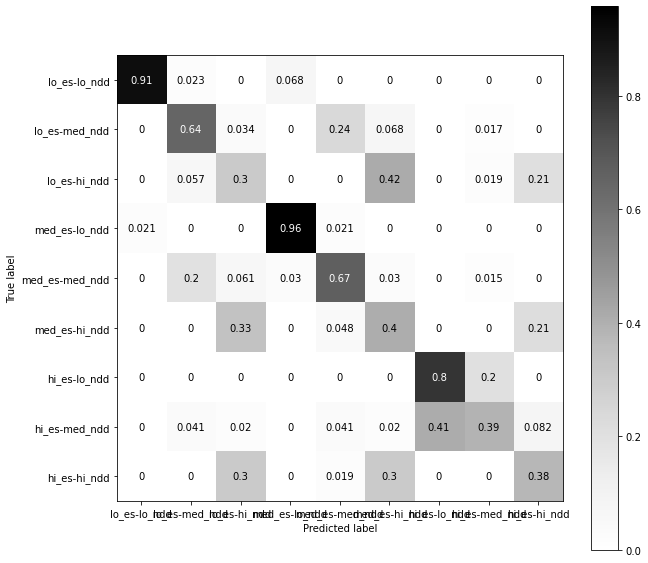

In [204]:
fig, ax = plt.subplots(figsize=(10, 10))
_ = plot_confusion_matrix(gbc_full, test_X, test_y, cmap='Greys', normalize="true", ax=ax, labels=all_labels)
#print(classification_report(test_y, predictions))

Text(0.5, 1.0, 'Permutation Importances (test set)')

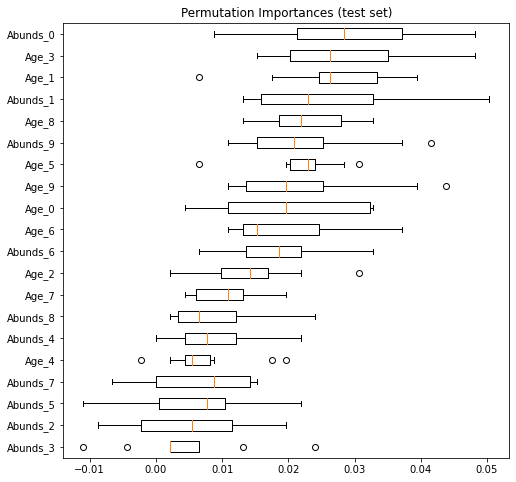

In [205]:
result = permutation_importance(gbc_full, test_X, test_y, n_repeats=10, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(8, 8))

ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=test_X.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")

## Turn off ndd (only look at lo values)

In [147]:
# Drop the e_s/ndd and model columns to take the data
lo_ndd_rows = sims_df["model"].apply(lambda x: "lo_ndd" in x)

X = sims_df[lo_ndd_rows].iloc[:, 2:-1]
y = sims_df[lo_ndd_rows]["model"]
y

0        lo_es-lo_ndd
3       med_es-lo_ndd
6        hi_es-lo_ndd
9        lo_es-lo_ndd
12      med_es-lo_ndd
            ...      
1248     hi_es-lo_ndd
1251     lo_es-lo_ndd
1254    med_es-lo_ndd
1257     hi_es-lo_ndd
1260     lo_es-lo_ndd
Name: model, Length: 421, dtype: object

In [148]:
%%time
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.25)
rfc = GradientBoostingClassifier(n_estimators=500, min_samples_leaf=10)
rfc.fit(train_X, train_y)
predictions = rfc.predict(test_X)

CPU times: user 2.84 s, sys: 19.1 ms, total: 2.86 s
Wall time: 2.85 s


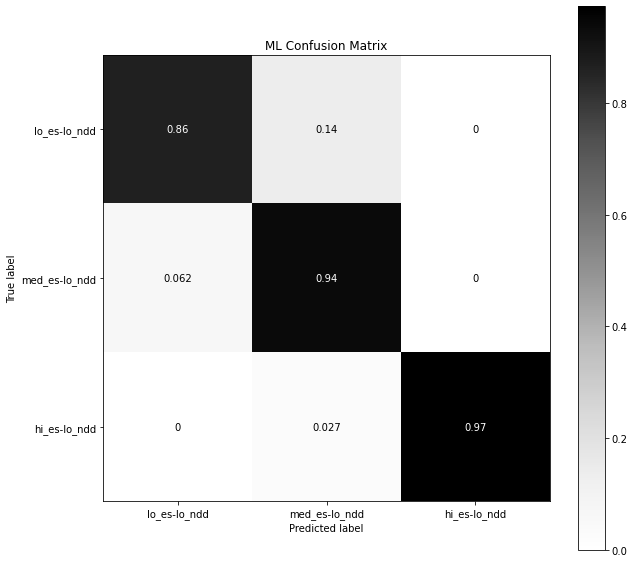

In [150]:
lo_ndd_labels = ['lo_es-lo_ndd', 'med_es-lo_ndd', 'hi_es-lo_ndd']

fig, ax = plt.subplots(figsize=(10, 10))
_ = plot_confusion_matrix(rfc, test_X, test_y, cmap='Greys', normalize="true", ax=ax, labels=lo_ndd_labels)
_ = plt.title("ML Confusion Matrix")

Text(0.5, 1.0, 'Permutation Importances (test set)')

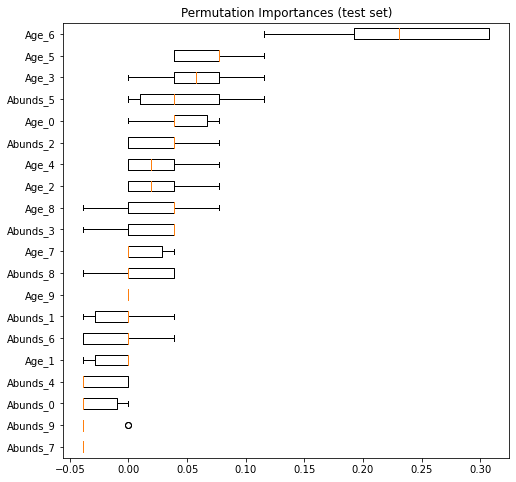

In [90]:
result = permutation_importance(rfc, test_X, test_y, n_repeats=10, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(8, 8))

ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=test_X.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")

## Look at the empirical data

In [136]:
#Reunion
re_ages = [0.7193396464076218, 0.06748956554590739, 0.37037593356333487, 0.02815927511276756, 0.12171336597321285, 0.10180970562703719, 0.022642568761800347, 0.05794101756357291, 0.06006412791448501, 0.2661623967485962]
re_abunds = [88, 20500, 180000, 49500, 465000, 150000, 200, 198000, 26354, 400]

#Mauritius
ma_ages = [0.7193396464076218, 0.143429941925178, 0.1146682342793967, 0.5442962791558384, 0.07625165171674868, 0.17162736542487242, 0.33737550893310325, 0.018616997618832228, 2.119025680390747, 0.029253141083029576, 0.04906314569492196, 0.2661623967485962]
ma_abunds = [520, 216, 560, 533, 200, 191, 68000, 350, 380, 200000, 4172, 300]

#Rodriguez
ro_ages = []
ro_abunds = []

print([len(x) for x in [re_ages, ma_ages, ro_ages]])

[10, 12, 0]


In [138]:
empirical_df = pd.DataFrame([re_ages, re_abunds, ma_ages, ma_abunds, ro_ages, ro_abunds],
                           index=["re_ages", "re_abunds", "ma_ages", "ma_abunds", "ro_ages", "ro_abunds"])
if scale_relative:
    empirical_df = empirical_df.div(empirical_df.sum(axis=1), axis=0)
empirical_df

,0,1,2,3,4,5,6,7,8,9,10,11
re_ages,0.396178,0.037170,0.203985,0.015509,0.067034,0.056072,0.012470,0.031911,0.033080,0.146590,NaN,NaN
re_abunds,0.000081,0.018807,0.165131,0.045411,0.426589,0.137609,0.000183,0.181644,0.024177,0.000367,NaN,NaN
ma_ages,0.156749,0.031254,0.024987,0.118606,0.016616,0.037399,0.073517,0.004057,0.461751,0.006374,0.010691,0.057999
ma_abunds,0.001888,0.000784,0.002033,0.001935,0.000726,0.000693,0.246894,0.001271,0.001380,0.726158,0.015148,0.001089
ro_ages,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ro_abunds,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [130]:
# Reunion
re_res = gbc_full.predict_proba(np.array(re_ages + re_abunds).reshape(1, -1))
pd.DataFrame(re_res, columns=gbc_full.classes_)

,hi_es-hi_ndd,hi_es-lo_ndd,hi_es-med_ndd,lo_es-hi_ndd,lo_es-lo_ndd,lo_es-med_ndd,med_es-hi_ndd,med_es-lo_ndd,med_es-med_ndd
0,3.858110e-11,0.138088,0.673213,2.545440e-10,0.000002,0.007963,0.000066,0.042565,0.138103


In [102]:
ma_res = gbc_full.predict_proba(np.array(ma_ages + ma_abunds).reshape(1, -1))
display(pd.DataFrame(ma_res, columns=gbc_full.classes_))

,hi_es-hi_ndd,hi_es-lo_ndd,hi_es-med_ndd,lo_es-hi_ndd,lo_es-lo_ndd,lo_es-med_ndd,med_es-hi_ndd,med_es-lo_ndd,med_es-med_ndd
0,7.242526e-07,1.416757e-12,0.999904,0.000017,1.296301e-07,0.000075,0.000002,4.908219e-07,5.316786e-07


,hi_es-hi_ndd,hi_es-lo_ndd,hi_es-med_ndd,lo_es-hi_ndd,lo_es-lo_ndd,lo_es-med_ndd,med_es-hi_ndd,med_es-lo_ndd,med_es-med_ndd
0,7.242526e-07,1.416757e-12,0.999904,0.000017,1.296301e-07,0.000075,0.000002,4.908219e-07,5.316786e-07


In [ ]:
ro_res = gbc_full.predict_proba(np.array(ro_ages + ro_abunds).reshape(1, -1))
display(pd.DataFrame(re_res, columns=gbc_full.classes_))

12.280000000000001 541.7400000000001
[[1.3862943611198906, 2.5649493574615367, 1.0986122886681098, 1.0986122886681098, 4.04305126783455, 6.042632833682381, 5.056245805348308, 8.500250470685925, 5.484796933490655, 5.71042701737487], [5.438079308923196, 5.958424693029782, 6.9584483932976555, 7.2196420401307355, 7.001245622069476, 6.628041376179533, 7.060476365999801, 6.77078942390898, 7.741099090035366, 7.272398392570047], [8.992681750892542, 6.873163834212518, 5.846438775057725, 5.840641657373398, 7.172424577124845, 6.297109319933935, 7.291656209174461, 5.438079308923196, 0.0, 0.0]]


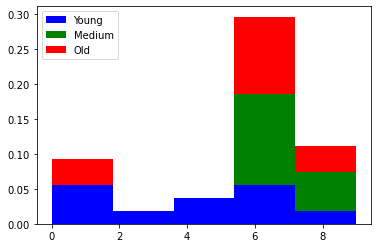

In [199]:
ag = pd.concat([ages.iloc[0], ages.iloc[1], ages.iloc[3]])
ab = pd.concat([abunds.iloc[0], abunds.iloc[1], abunds.iloc[3]])
ab = np.log(ab+1)
#_ = plt.hist(np.log(a+1), bins=10)
sorted([(x,y) for x,y in zip(ag, ab)], key=lambda z: z[1])
qthirty, qsixty = np.quantile(ag, [0.33, 0.66])
print(qthirty, qsixty)

dat = [[], [], []]
for t_age, t_abund in zip(ag, ab):
    if t_age < qthirty:
        dat[2].append(t_abund)
    elif t_age < qsixty:
        dat[1].append(t_abund)
    else:
        dat[0].append(t_abund)
print(dat)
colors=["blue", "green", "red"]
labels=["Young", "Medium", "Old"]
_ = plt.hist(dat, stacked=True, bins=5, density=True, color=colors, label=labels)
plt.legend()
